# PROJECT 4 - ROADWISE

## Import the required libraries

In [2]:
# Import required libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from mrjob.job import MRJob
import geopandas as gpd
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

## Create DataFrame and Data Cleane-Up

In [3]:
# Read the CSV file using Pandas
df = pd.read_csv('US_Accidents_March23.csv')

In [4]:
# Display the first 5 rows of the DataFrame
display(df.head())

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
# Display basic information of the DataFrame
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

None

In [6]:
# To find the percentage of False/True for the columns with bool data type
# Set the list of columns to check
columns_to_check = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# Loop through each column and print the value counts
for col in columns_to_check:
    print(f"Column: {col}")
    print(df[col].value_counts(normalize=True) * 100)
# Add an empty line for spacing for better readibility
    print()  

Column: Amenity
Amenity
False    98.753506
True      1.246494
Name: proportion, dtype: float64

Column: Bump
Bump
False    99.954531
True      0.045469
Name: proportion, dtype: float64

Column: Crossing
Crossing
False    88.694119
True     11.305881
Name: proportion, dtype: float64

Column: Give_Way
Give_Way
False    99.526655
True      0.473345
Name: proportion, dtype: float64

Column: Junction
Junction
False    92.607235
True      7.392765
Name: proportion, dtype: float64

Column: No_Exit
No_Exit
False    99.747101
True      0.252899
Name: proportion, dtype: float64

Column: Railway
Railway
False    99.133339
True      0.866661
Name: proportion, dtype: float64

Column: Roundabout
Roundabout
False    99.996778
True      0.003222
Name: proportion, dtype: float64

Column: Station
Station
False    97.387543
True      2.612457
Name: proportion, dtype: float64

Column: Stop
Stop
False    97.22619
True      2.77381
Name: proportion, dtype: float64

Column: Traffic_Calming
Traffic_Calming
Fa

In [7]:
# Change the data type to datetime from object
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Check for any NaT values and handle if necessary
print(df['End_Time'].isna().sum())

# Extract Day, Month, Year, and Weekday/Weekend information
df['Day'] = df['End_Time'].dt.day.astype('Int64')
df['Month'] = df['End_Time'].dt.month.astype('Int64')
df['Year'] = df['End_Time'].dt.year.astype('Int64')
df['Weekday/Weekend'] = df['End_Time'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
df['Day_of_the_Week'] = df['End_Time'].dt.day_name()

# Add the new column Left_Zipcode by using the left 5 digit of the zipcode column
df['Left_Zipcode'] = df['Zipcode'].str[:5].astype('Int64')

# Display the updated DataFrame
print(df)

743166
                ID   Source  Severity           Start_Time  \
0              A-1  Source2         3  2016-02-08 05:46:00   
1              A-2  Source2         2  2016-02-08 06:07:59   
2              A-3  Source2         2  2016-02-08 06:49:27   
3              A-4  Source2         3  2016-02-08 07:23:34   
4              A-5  Source2         2  2016-02-08 07:39:07   
...            ...      ...       ...                  ...   
7728389  A-7777757  Source1         2  2019-08-23 18:03:25   
7728390  A-7777758  Source1         2  2019-08-23 19:11:30   
7728391  A-7777759  Source1         2  2019-08-23 19:00:21   
7728392  A-7777760  Source1         2  2019-08-23 19:00:21   
7728393  A-7777761  Source1         2  2019-08-23 18:52:06   

                   End_Time  Start_Lat   Start_Lng   End_Lat    End_Lng  \
0       2016-02-08 11:00:00  39.865147  -84.058723       NaN        NaN   
1       2016-02-08 06:37:59  39.928059  -82.831184       NaN        NaN   
2       2016-02-08 07:1

In [8]:
# Drop columns that are not important and False % over 86 on columns with bool data type
df_dropped= df.drop(columns = ['ID','Source', 'Start_Time','Start_Lat', 'Start_Lng', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Wind_Direction', 'Precipitation(in)', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'No_Exit', 'No_Exit', 'Roundabout', 'Station', 'Junction', 'Traffic_Calming', 'Turning_Loop'], axis = 1)

In [9]:
df_dropped.isnull().sum()

Severity                   0
End_Time              743166
End_Lat              3402762
End_Lng              3402762
Distance(mi)               0
Description                5
Street                 10869
City                     253
County                     0
State                      0
Zipcode                 1915
Temperature(F)        163853
Visibility(mi)        177098
Wind_Speed(mph)       571233
Weather_Condition     173459
Railway                    0
Stop                       0
Traffic_Signal             0
Sunrise_Sunset         23246
Day                   743166
Month                 743166
Year                  743166
Weekday/Weekend            0
Day_of_the_Week       743166
Left_Zipcode            1915
dtype: int64

In [10]:
# Drop rows with missing values in specific columns
df_cleaned = df_dropped.dropna(subset=['End_Time', 'End_Lat', 'End_Lat', 'Description', 'Street', 'City', 'Zipcode', 'Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition', 'Sunrise_Sunset'])


In [11]:
# Check to see the dataframe does not have any na
df_cleaned.isnull().sum()

Severity             0
End_Time             0
End_Lat              0
End_Lng              0
Distance(mi)         0
Description          0
Street               0
City                 0
County               0
State                0
Zipcode              0
Temperature(F)       0
Visibility(mi)       0
Wind_Speed(mph)      0
Weather_Condition    0
Railway              0
Stop                 0
Traffic_Signal       0
Sunrise_Sunset       0
Day                  0
Month                0
Year                 0
Weekday/Weekend      0
Day_of_the_Week      0
Left_Zipcode         0
dtype: int64

In [12]:
# Review summary statistics of the data
df_cleaned.describe().T

,count,mean,min,25%,50%,75%,max,std
Severity,3345887.0,2.122293,1.0,2.0,2.0,2.0,4.0,0.460408
End_Time,3345887,2021-02-15 20:59:26.641347840,2016-02-08 06:37:08,2020-05-22 03:34:01.500000,2021-06-22 08:55:00,2022-04-25 07:48:15,2023-03-31 23:59:00,NaN
End_Lat,3345887.0,36.277782,24.566013,33.461649,36.167253,40.245868,49.075,5.30458
End_Lng,3345887.0,-96.009505,-124.545748,-117.837244,-88.75071,-80.309485,-67.109242,18.139976
Distance(mi),3345887.0,0.801045,0.0,0.061,0.264,0.858,155.186,1.780324
Temperature(F),3345887.0,61.188178,-89.0,48.0,63.0,76.0,207.0,19.20738
Visibility(mi),3345887.0,9.09681,0.0,10.0,10.0,10.0,140.0,2.64693
Wind_Speed(mph),3345887.0,7.569969,0.0,3.5,7.0,10.0,1087.0,5.57111
Day,3345887.0,15.840319,1.0,8.0,16.0,23.0,31.0,8.671301
Month,3345887.0,6.794641,1.0,3.0,7.0,10.0,12.0,3.763956


## DATA VISUALIZATION

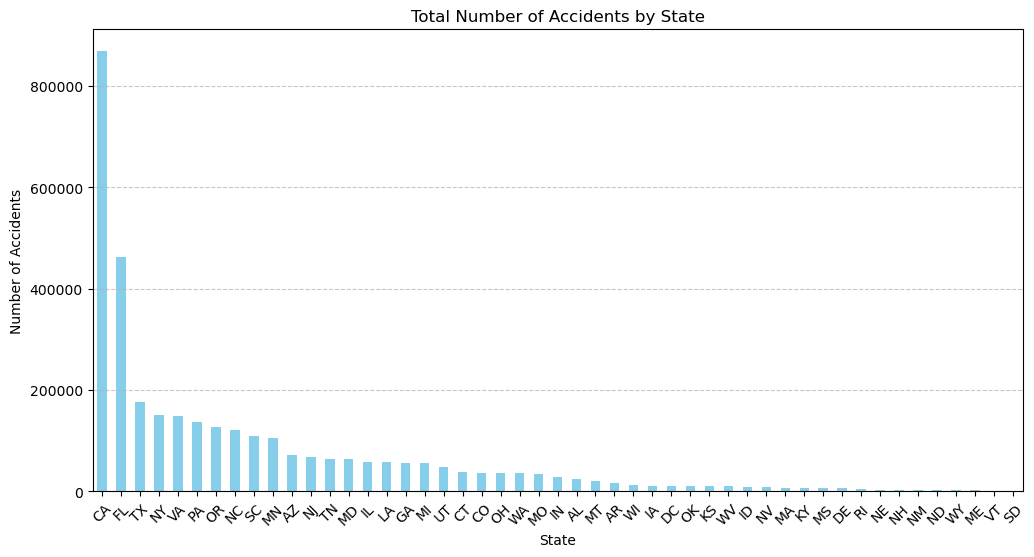

In [13]:
# Group the data by the state
state_accident_count = df_cleaned['State'].value_counts()

# Plot a bar chart for the total number of accidents by state
plt.figure(figsize=(12, 6))
state_accident_count.plot(kind='bar', color='skyblue')
plt.title('Total Number of Accidents by State')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

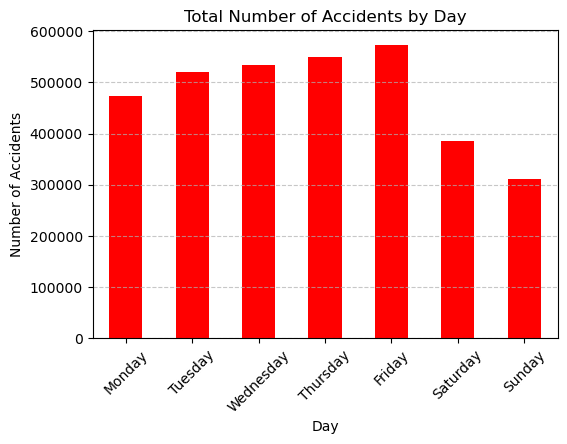

In [14]:
# Group the data by the Day_of_the_Week
day_accident_count = df_cleaned['Day_of_the_Week'].value_counts()

# Define the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot a bar chart for the total number of accidents by Day_of_the_Week
plt.figure(figsize=(6, 4))
day_accident_count.loc[day_order].plot(kind='bar', color='red')
plt.title('Total Number of Accidents by Day')
plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

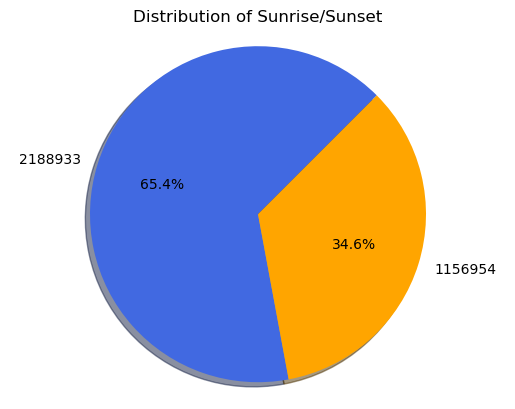

In [15]:
# Group the data by the Day_of_the_Week
sunrise_sunset_count = df_cleaned['Sunrise_Sunset'].value_counts()

# Plot a pie chart
plt.title('Distribution of Sunrise/Sunset')
plt.pie(sunrise_sunset_count, labels=sunrise_sunset_count, autopct='%1.1f%%', shadow = True, startangle=45, colors=['royalblue', 'orange'])
plt.title('Distribution of Sunrise/Sunset')
plt.axis("equal")
plt.show()

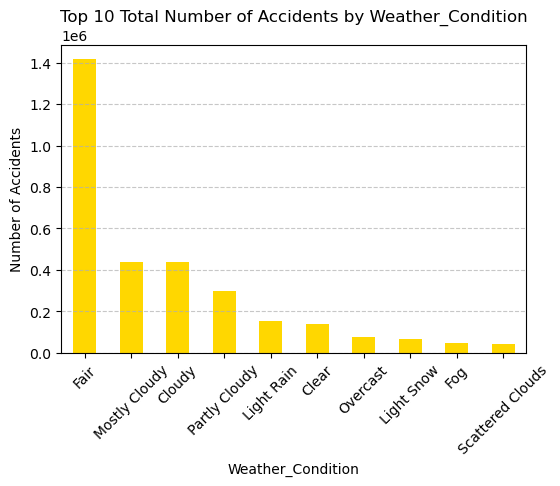

In [16]:
# Find the top 10 count from 'Weather_Condition' 
weather_counts = df_cleaned['Weather_Condition'].value_counts()
top_10_weather_counts = weather_counts.head(10)

# Plot a bar chart for the the top 10 count from 'Weather_Condition'
plt.figure(figsize=(6, 4))
top_10_weather_counts.plot(kind='bar', color='Gold')
plt.title('Top 10 Total Number of Accidents by Weather_Condition')
plt.xlabel('Weather_Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Training the Data with Unsupervised Machine Learning

In [17]:
# Set the columns that need for scaling
data_to_scale = df_cleaned[['End_Lat', 'End_Lng', 'Severity', 'Left_Zipcode']]

In [18]:
# Scaling the numeric columns
#df_cleaned_scaled = StandardScaler().fit_transform(locations)
df_cleaned_scaled = StandardScaler().fit_transform(data_to_scale)

In [19]:
# Create a a list to store inertia values and the values of k
inertia = []
k_values = list(range(1, 11))

In [20]:
# Create a for loop where each value of k is evaluated using the K-means algorithm
for k in k_values:
    k_model = KMeans(n_clusters=k, random_state=0)
    k_model.fit(df_cleaned_scaled)
    inertia.append(k_model.inertia_)

In [21]:
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k_values, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,1.338355e+07
1,2,7.734707e+06
2,3,5.756966e+06
3,4,3.354059e+06
4,5,2.819179e+06


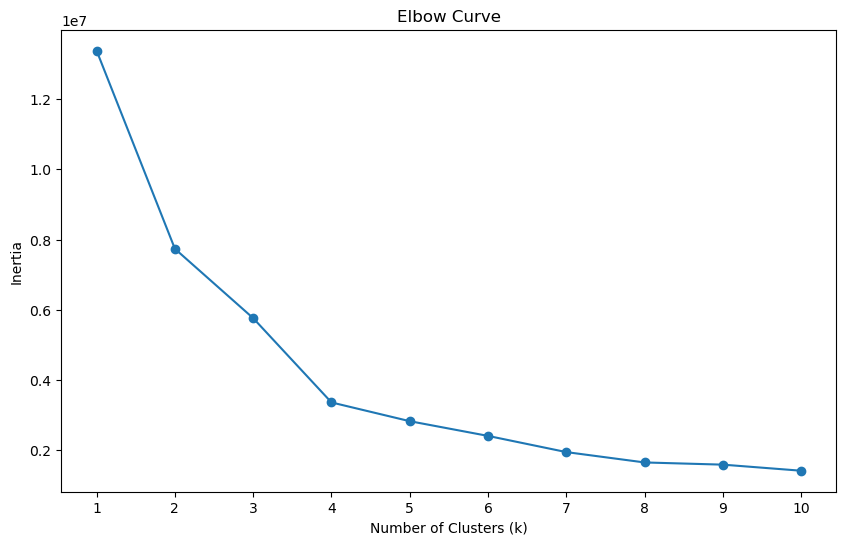

In [22]:
# Plot the Scaled DataFrame
plt.figure(figsize=(10, 6))
plt.plot(df_elbow['k'], df_elbow['inertia'], marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

In [23]:
# Define the model with 4 clusters
model = KMeans(n_clusters=4, random_state=3)

# Fit the model
model.fit(df_cleaned_scaled)

# Make predictions
k_4 = model.predict(df_cleaned_scaled)

# Create a copy of the preprocessed data
df_cleaned_predictions = df_cleaned.copy()

# Add a class column with the labels
df_cleaned_predictions['Collisions'] = k_4

In [24]:
# Create a a list to store inertia values and the values of k
inertia = []
k_values = list(range(1, 11))

In [25]:
# Create a for loop where each value of k is evaluated using the K-means algorithm
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=3)
    kmeans.fit(df_cleaned_scaled)
    inertia.append(kmeans.inertia_)

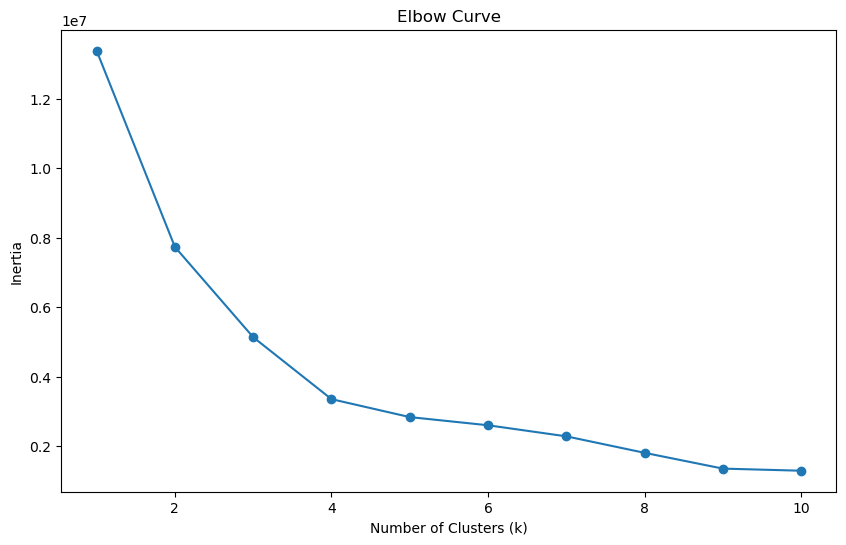

In [26]:
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

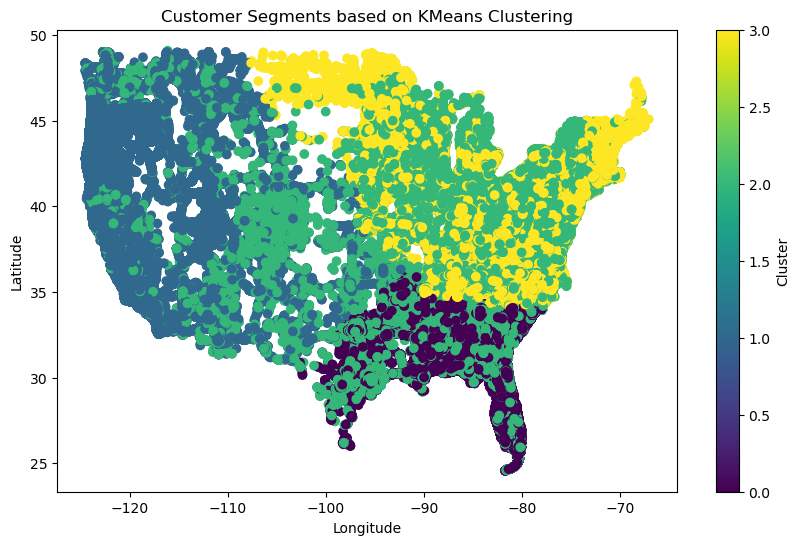

In [27]:
# Plot the Predictions DataFrame
plt.figure(figsize=(10, 6)) 
plt.scatter(df_cleaned_predictions['End_Lng'], df_cleaned_predictions['End_Lat'], c=df_cleaned_predictions['Collisions'], cmap='viridis', marker='o') 
plt.title('Customer Segments based on KMeans Clustering') 
plt.xlabel('Longitude') 
plt.ylabel('Latitude') 
plt.colorbar(label='Cluster') 
plt.show()

In [28]:
# Calculate Within-Cluster Sum of Squares (WCSS)
wcss = model.inertia_
# Calculate Total Sum of Squares (TSS)
tss = np.sum((df_cleaned_scaled - np.mean(df_cleaned_scaled, axis=0)) ** 2)
# Calculate the R^2 score
r_squared = 1 - (wcss / tss)
print(f'R^2 Score: {r_squared}')

R^2 Score: 0.7493888211640856


## Filter the df_cleaned with State 'CA' and Year from 2021-2023 and reset Index

In [29]:
# From df_cleaned dataframe, create dataframe for State 'CA' and year from 2020 to 2022 and reindex the dataframe
df_ca = df_cleaned[(df_cleaned['State'] == 'CA') & (df_cleaned['Year'] >= 2020) & (df_cleaned['Year'] <= 2022)].reset_index(drop=True)

In [30]:
# Check the dataframe information
df_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636355 entries, 0 to 636354
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Severity           636355 non-null  int64         
 1   End_Time           636355 non-null  datetime64[ns]
 2   End_Lat            636355 non-null  float64       
 3   End_Lng            636355 non-null  float64       
 4   Distance(mi)       636355 non-null  float64       
 5   Description        636355 non-null  object        
 6   Street             636355 non-null  object        
 7   City               636355 non-null  object        
 8   County             636355 non-null  object        
 9   State              636355 non-null  object        
 10  Zipcode            636355 non-null  object        
 11  Temperature(F)     636355 non-null  float64       
 12  Visibility(mi)     636355 non-null  float64       
 13  Wind_Speed(mph)    636355 non-null  float64 

In [33]:
# Save df_ca to csv file
df_ca.to_csv('collisions_df_ca.csv', index=False)

## Focus the data on Los Angeles only from 2021-2023

In [34]:
# From df_ca dataframe, create data frame for Los Angeles and year >= 2021 and reindex the dataframe
df_la = df_ca[df_ca['City'] == 'Los Angeles'].reset_index(drop=True)

In [35]:
# Review the dataframe information
df_la.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53437 entries, 0 to 53436
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Severity           53437 non-null  int64         
 1   End_Time           53437 non-null  datetime64[ns]
 2   End_Lat            53437 non-null  float64       
 3   End_Lng            53437 non-null  float64       
 4   Distance(mi)       53437 non-null  float64       
 5   Description        53437 non-null  object        
 6   Street             53437 non-null  object        
 7   City               53437 non-null  object        
 8   County             53437 non-null  object        
 9   State              53437 non-null  object        
 10  Zipcode            53437 non-null  object        
 11  Temperature(F)     53437 non-null  float64       
 12  Visibility(mi)     53437 non-null  float64       
 13  Wind_Speed(mph)    53437 non-null  float64       
 14  Weathe

In [36]:
# Save df_la to csv
df_la.to_csv('collisions_df_la.csv', index=False)

## Creating GeoJson file for df_la

In [37]:
# Convert DataFrame to GeoDataFrame
gdf_la = gpd.GeoDataFrame(df_la, geometry=gpd.points_from_xy(df_la['End_Lng'], df_la['End_Lat']))

In [38]:
# Convert Timestamp column to string
gdf_la['End_Time'] = gdf_la['End_Time'].astype(str)

# Create GeoJson data file
gdf_la.to_file("data.geojson", driver="GeoJSON")